In [1]:
# !pip install PyArrow

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import DataPreprocessing

# Spark session

In [3]:
# spark = SparkSession.builder \
#     .master("local[*]") \
#     .appName("DataPreprocessing") \
#     .config('spark.sql.execution.arrow.pyspark.enabled', True) \
#     .config('spark.sql.session.timeZone', 'UTC') \
#     .config('spark.driver.memory', '48G') \
#     .config('spark.ui.showConsoleProgress', True) \
#     .config('spark.sql.repl.eagerEval.enabled', True) \
#     .getOrCreate()

spark = SparkSession.builder.appName('DataPreprocessing').getOrCreate()

sc=spark.sparkContext

# Reading the data

In [4]:
file_name='Google-Playstore'

In [5]:
df = DataPreprocessing.read_data(spark)
# df.show(5)

# Get info about the data

In [6]:
# DataPreprocessing.get_info(df)

# Show nulls in each column

In [7]:
# DataPreprocessing.show_nulls(df)

# Dealing with missing values

In [8]:
# df_copy= DataPreprocessing.handle_missing_values(df)

# Outliers

In [9]:
new_df_with_no_outliers= DataPreprocessing.detect_outliers(df)


Number of outliers in Rating: 0 (0.00%)
Number of outliers in Rating Count: 388994 (16.82%)
Number of outliers in Minimum Installs: 260554 (11.27%)
Number of outliers in Maximum Installs: 407678 (17.63%)
Number of outliers in Price: 44943 (1.94%)
Number of rows before removing outliers: 2312944
Number of rows after removing outliers: 1961130


### Display boxplot for numerical columns before and after removing the outliers

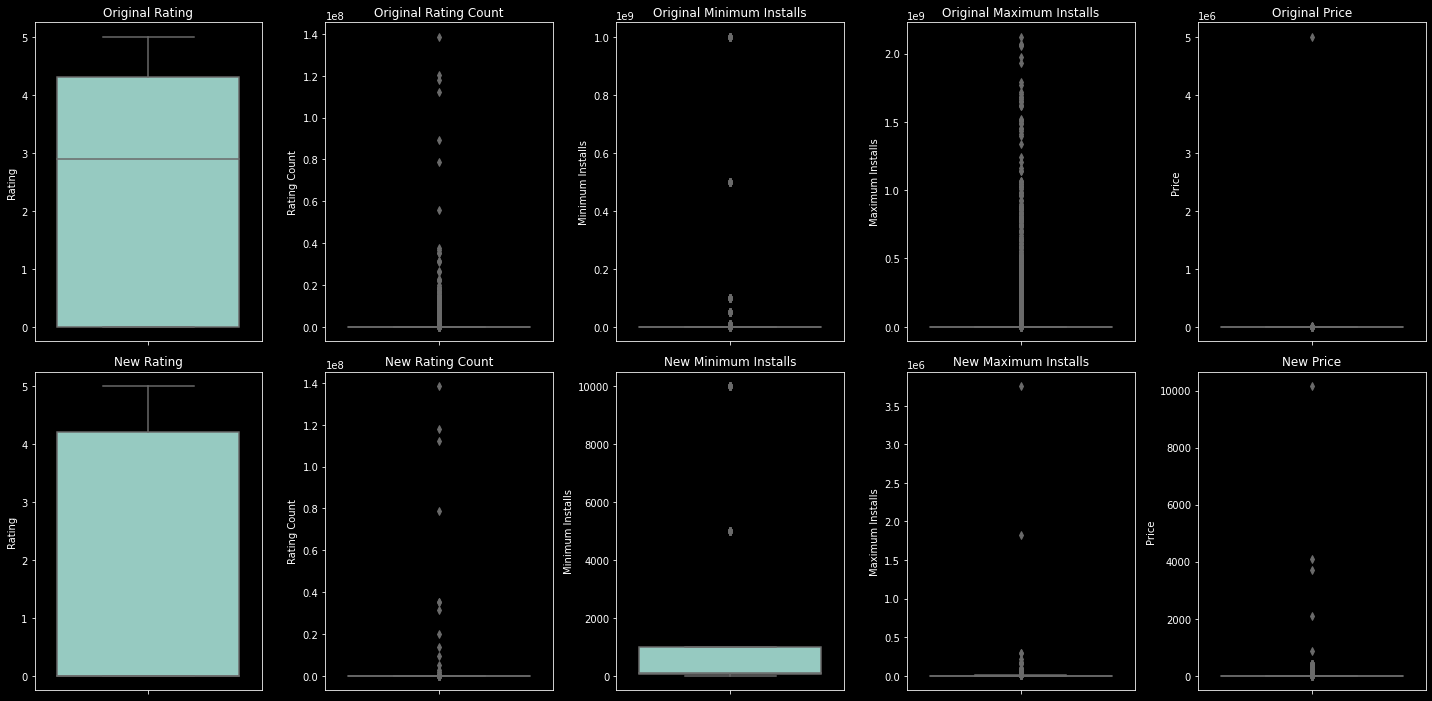

In [18]:

DataPreprocessing.boxplot_for_outliers(df, new_df_with_no_outliers)


### Prepare 'Size' column

In [11]:
# DataPreprocessing.handle_size_col(df)

In [12]:
# print('The percentage of "Varies with app" is too low, then can remove all rows with this value')
# df = df.filter(df.Size != 'Varies with device')

### Currency column

In [13]:
# DataPreprocessing.currency_col(df)

In [14]:
# print("Since most of the values are USD, then we can remove this column")
# df = DataPreprocessing.remove_useless_col(df, ['Currency'])

### Write df to csv

In [15]:
# pd_df = df.toPandas()
# pd_df.to_csv('../Dataset/'+file_name+'.csv', index=False)

### Splitting the data 

In [16]:
# DataPreprocessing.split_data()

### Prepare dataset for RDD

In [17]:
# DataPreprocessing.delimiter_to_comma()
# DataPreprocessing.delimiter_to_comma(file_name='train')
# DataPreprocessing.delimiter_to_comma(file_name='val')
# DataPreprocessing.delimiter_to_comma(file_name='test')